In [4]:
import pandas as pd
import matplotlib.pyplot as plt

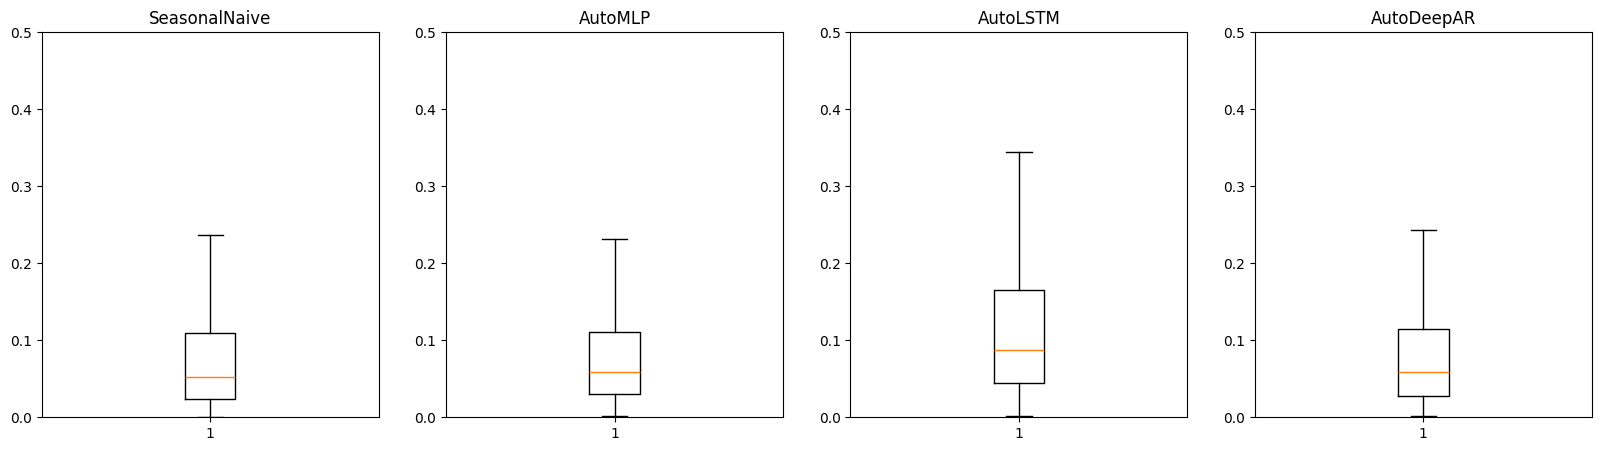

In [5]:
smape_df = pd.read_csv("empirical_analysis/M3_Monthly_DistributionLoss/smape_M3_Monthly_DistributionLoss.csv")

models_names = list(smape_df.columns[1:])

fig, ax = plt.subplots(1, len(models_names), figsize=(len(models_names)*5, 5))

for i, model_name in enumerate(models_names):
    ax[i].boxplot(smape_df[model_name], showfliers=False)
    ax[i].set_title(model_name)
    ax[i].set_ylim((0, 0.5))

plt.show()

In [8]:
auc_logloss_df = pd.read_csv("empirical_analysis/M3_Monthly_DistributionLoss/auc_logloss_percentiles_M3_Monthly_DistributionLoss.csv")
auc_logloss_df

,Model_Percentile,AUC,LogLoss
0,SeasonalNaive_90,0.768577,6.496607
1,AutoMLP_90,0.644962,8.776413
2,AutoLSTM_90,0.501264,12.032077
3,AutoDeepAR_90,0.716511,7.413577
4,SeasonalNaive_95,0.680006,7.236913
5,AutoMLP_95,0.542139,9.272755
6,AutoLSTM_95,0.500233,10.059330
7,AutoDeepAR_95,0.540086,9.329539
8,SeasonalNaive_99,0.567809,6.658549
9,AutoMLP_99,0.501690,7.156993
